In [ ]:
!pip install --progress-bar off --quiet poetry
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git

In [1]:
import ergo
import seaborn

import warnings
import ssl
import pandas as pd
from datetime import timedelta, date

warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="plotnine")
ssl._create_default_https_context = ssl._create_unverified_context
pd.set_option('precision', 2)

# Forecasting with Ergo

## Choose a decision-relevant question

### How many ventilators will be needed in El Paso?

I want to predict this question:

> How many patients with Covid-19 in El Paso County will require invasive ventilation on the day when the number of hospital admissions of cases peak?

Background:

- El Paso is a county in Texas (population 850,000)
- They're preparing for the impact of COVID-19
- This questions is part of a series of a dozen questions that have been formulated in partnership between [Metaculus](https://www.metaculus.com) and administrators at Texas Tech University Health Sciences Center, El Paso
- The answers will guide on-the-ground decision
- This questions is particularly decision-relevant: it's important to have enough ventilators on the day when most are needed, but if you don't need them, they might be put to better use elsewhere

### Loading question data from the Metaculus crowd prediction platform

Ergo can read and write from Metaculus, Foretold, and other crowd prediction sites.

The ventilation questions is [a question](https://pandemic.metaculus.com/questions/4137/) on the crowd prediction site Metaculus, so I'll load it from there:

In [2]:
metaculus = ergo.Metaculus(username="oughtpublic", password="123456", api_domain="pandemic")
peak_ventilators_question = metaculus.get_question(4201)
peak_ventilators_question

<MetaculusQuestion title="How many patients with Covid-19 in El Paso County will require invasive ventilation on the day when the number of hospital admissions of cases peak?">

This will allow us to compare our prediction to the Metaculus community, and to submit our prediction to the platform.

### Custom questions

We don't have to use questions on prediction platforms. We could also define our own questions:

```
question = ergo.Question(title="How long will I live?")
```

But in this tutorial I'll stick with the ventilation question on Metaculus.

## A wild guess

I'll start by making an uninformed baseline prediction. I want to do this before I look at any data or crowd guesses because having this data point will tell me what I'm learning as I go through the forecasting process.

What is my 90% confidence interval for the number of ventilators needed? I think there is a 

- less than 5% chance that <3 people require ventilation
- less than 5% chance that >100 people require ventilation

So I'll go with a 90% confidence interval of [3, 100].

I don't know much about El Paso, ICUs, or ventilators. I feel pretty uncertain and assign non-negligible probability to higher values. I'll go with a lognormal distribution that assigns more probability to the tails than a normal distribution.

### Distributions in Ergo

In Ergo, I can generate a single sample from this distribution like this:

In [3]:
ergo.lognormal_from_interval(3, 100)

DeviceArray(20.191326, dtype=float32)

To get many samples, I use `ergo.run`:

In [4]:
def peak_ventilators():
    """
    How many patients with Covid-19 in El Paso County will require invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?
    """          
    return ergo.lognormal_from_interval(3, 100)

samples = ergo.run(peak_ventilators, num_samples=1000)

samples

,output
0,91.75
1,4.04
2,21.08
3,82.26
4,49.40
...,...
995,14.95
996,10.95
997,6.60
998,7.30


### Visualizing distributions

I can visualize these samples using the `show_prediction` method associated with my question:

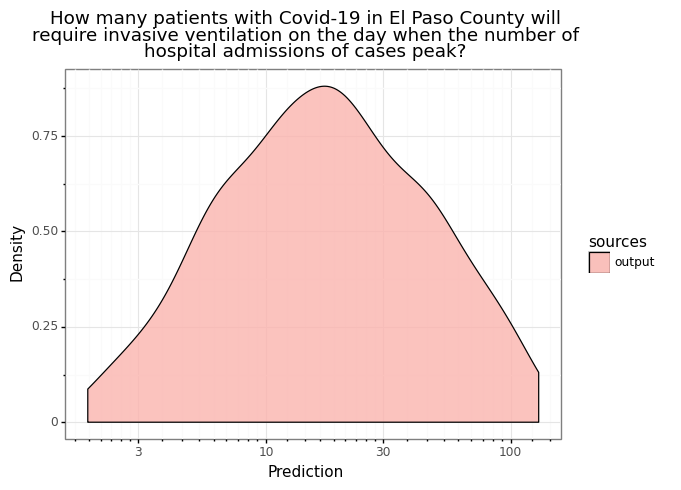

In [5]:
peak_ventilators_question.show_prediction(samples)

## Model V1: My wild guess

I'll wrap my guess in a `Model` class so that I can more easily build on it step by step by inheriting from it, adding more methods, and replacing methods with better implementations:

In [6]:
class ModelV1:
    
    def peak_ventilators(self):
        """
        How many patients with Covid-19 in El Paso County will require invasive 
        ventilation on the day when the number of hospital admissions of cases 
        peak?
        """       
        return ergo.lognormal_from_interval(3, 100)

    def run(self):
        samples = ergo.run(self.peak_ventilators, num_samples=1000)
        peak_ventilators_question.show_prediction(samples)

This doesn't change the result:

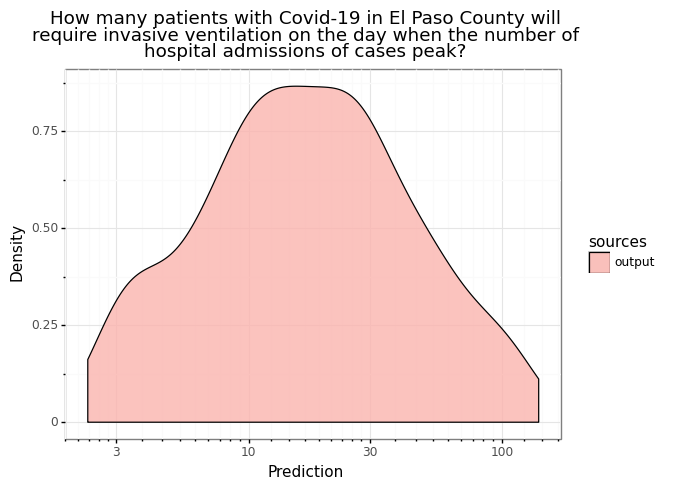

In [7]:
ModelV1().run()

It's still an uninformed guess.

## Model V2: Decomposing the ventilation question

My strategy for this question will be to break it into pieces and then improve my estimate for each piece. I'll start by estimating the peak ventilators needed as the product of two things:

1. How many patients will be in the ICU on peak day?
2. What fraction of those will need ventilators?

For both of these I'll make pretty uninformed guesses for now:

1. I guess that about 5 to 200 people will be in the ICU on peak day (but I have no idea)
2. I'd guess that 1 out of 3 will need ventilators (but I have no idea)

For ICU cases, I use the same `lognormal_from_interval` function I used above.

For ventilation need, I'll use a beta-binomial distribution:

In [8]:
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation
    """
    return ergo.beta_from_hits(1, 3)

This distribution looks like this:

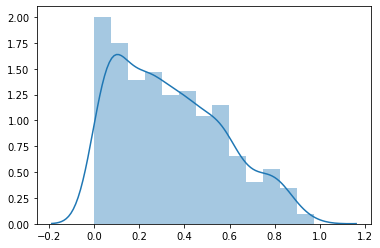

In [9]:
samples = ergo.run(frac_icu_ventilation, num_samples=1000)
seaborn.distplot(samples)

My model now looks like this:

In [10]:
class ModelV2(ModelV1):
    
    def peak_ventilators(self):
        """
        How many patients with Covid-19 in El Paso County will require invasive 
        ventilation on the day when the number of hospital admissions of cases 
        peak?
        """
        return self.frac_icu_ventilation() * self.peak_icu_admissions()   
    
    def peak_icu_admissions(self):
        """
        How many patients with Covid-19 in El Paso County will be admitted to the
        ICU on the day when the number of hospital admissions of cases peak?
        """
        return ergo.lognormal_from_interval(5, 200)

    def frac_icu_ventilation(self):
        """
        Proportion of ICU admissions requiring ventilation
        """
        return ergo.beta_from_hits(1, 3)

This doesn't change the overall estimate much:

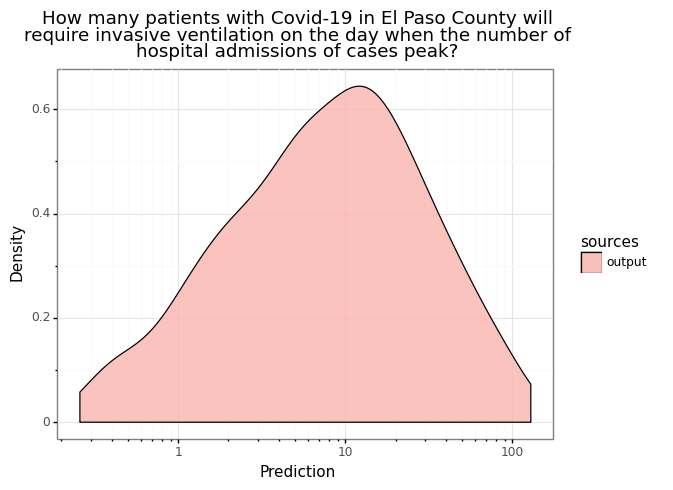

In [11]:
ModelV2().run()

I can also visualize parts of my model in the same way I visualized the standalone `frac_icu_ventilation` function:

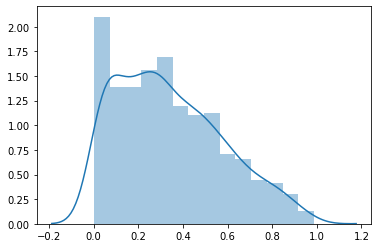

In [12]:
samples = ergo.run(ModelV2().frac_icu_ventilation, num_samples=1000)
seaborn.distplot(samples)

## Model V3: A better estimate for the fraction of ICU admits needing ventilation

I'll estimate the fraction of ICU admits that need ventilation by looking at [data from publications](https://pandemic.metaculus.com/questions/4154/#comment-28155). This is the approach followed by PabloStafforini et al on Metaculus.

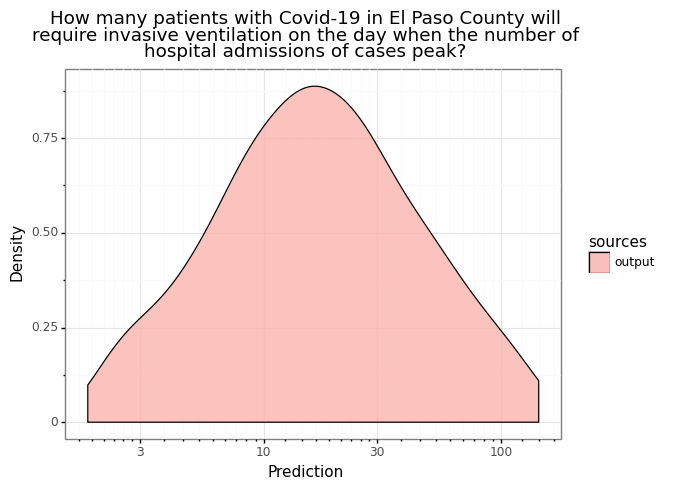

In [13]:
class ModelV3(ModelV2):

    def frac_icu_ventilation(self):
        """
        Proportion of ICU admissions requiring ventilation
        """
        ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
        icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
        return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

ModelV3().run()

This increased the overall estimate since I'd assumed that about 1/3 people need ventilation, but the empirical data says that about 1/2 do.

## Model V4: Decomposing the peak ICU admits question

How can I better estimate the number of ICU admits at peak? I'll break it down into:

1. What's the maximum number of hospital admissions at peak?
2. What fraction of those need to go to the ICU?

I'll again start by making pretty uninformed guesses for both of these questions. I assume that:

1. There's about 10 to 100 COVID-19 hospital admissions per day at peak
2. About half of those need to go to the ICU

In [14]:
class ModelV4(ModelV3):

    def peak_icu_admissions(self):
        """
        How many patients with Covid-19 in El Paso County will be admitted to the
        ICU on the day when the number of hospital admissions of cases peak?

        Following @Tamay's approach:
        https://pandemic.metaculus.com/questions/4204/
        """
        max_patients = self.max_30d_hospital_confirmed_for_peak()
        return max_patients * self.frac_patients_icu()
    
    def max_30d_hospital_confirmed_for_peak(self):
        """
        What will the maximum number of in-hospital lab-confirmed COVID-19 
        patients in El Paso County, in the 30-day period during which the "peak"
        occurs?
        """        
        return ergo.lognormal_from_interval(10, 100)
    
    def frac_patients_icu(self):
        """
        What portion of in-hospital cases in El Paso County will require admission
        to the ICU?
        """
        return ergo.beta_from_hits(1, 2)

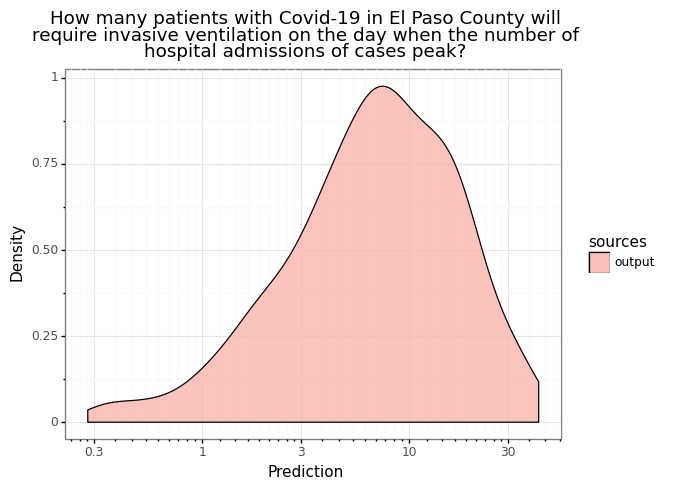

In [15]:
ModelV4().run()

## Model V5: A better estimate for the fraction of patients that need to go to the ICU

To get a real estimate for the number of hospital admits that need to go to the ICU, I'll look at what happened in other countries. This is [the approach followed by katifish](https://pandemic.metaculus.com/questions/4155/#comment-28054) on Metaculus.

In [16]:
class ModelV5(ModelV4):
    
    def frac_patients_icu(self):
        """
        What portion of in-hospital cases in El Paso County will require admission
        to the ICU?
        """
        alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
        return ergo.random_choice([
          ergo.beta_from_hits(alpha * 121, alpha * 508),
          ergo.beta_from_hits(alpha * 181, alpha * 507),
        ])

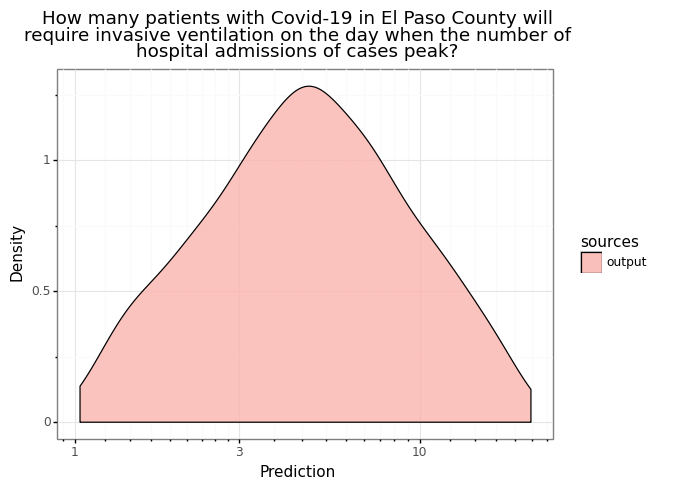

In [17]:
ModelV5().run()

## Model V6: Decomposing the maximum-patients question

What is the maximum number of people in the hospital around peak infection time? I'll break this one down into:

1. When is the peak infection date?
2. What is the largest number of people in the hospital in the 30-day period around this date?

Again I'll start with uninformed guesses.

In [18]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


class ModelV6(ModelV5):
    
    def max_30d_hospital_confirmed_for_peak(self):
        """
        What will the maximum number of in-hospital lab-confirmed COVID-19 
        patients in El Paso County, in the 30-day period during which the "peak"
        occurs?
        """        
        peak = self.peak_infection_date()
        days = daterange(peak - timedelta(15), peak + timedelta(15))
        return max(self.hospital_confirmed_for_date(day) for day in days)    
    
    def peak_infection_date(self) -> date:
        """
        When will El Paso County, Texas, experience its first peak number of COVID
        infections?
        """
        start_date = date(2020, 4, 1)                
        end_date = date(2020, 7, 1)        
        return ergo.random_choice(list(daterange(start_date, end_date)))
    
    def hospital_confirmed_for_date(self, date: date) -> int:
        """
        The total number of lab-confirmed COVID-19 patients in El Paso County in
        the hospital on this date
        """
        return ergo.lognormal_from_interval(10, 100)

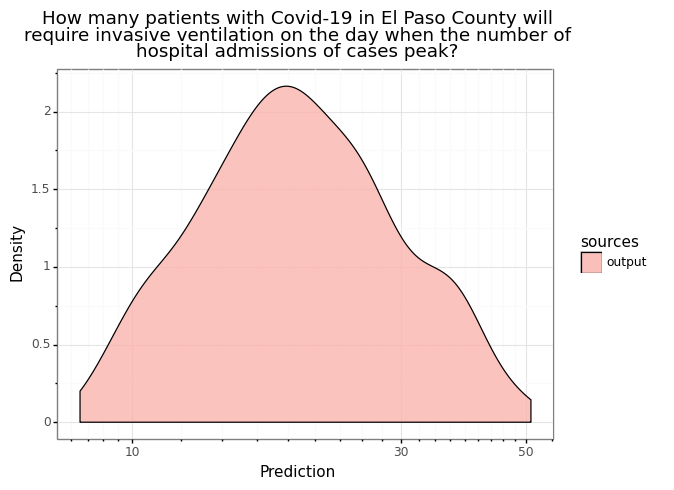

In [19]:
ModelV6().run()

## Model V7: A better estimate for peak infection date and hospitalizations

To better estimate peak infection date and hospitalizations, I need actual data. A lot happens here, sorry!

In [20]:
from ergo.contrib.el_paso import *

START_DATE = date(2020, 4, 1)
el_paso_cases = texas_data.get_el_paso_data()
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed
compiled_data = krismoore.get_krismoore_data()
projected_cases = onlyasith.get_onlyasith_results()

In [21]:
class ModelV7(ModelV6):
    
    def __init__(self):
        self.hospital_confirmed_from_daily_infected_model = get_daily_hospital_confirmed(compiled_data, self.daily_infections)
        super(ModelV7, self).__init__()

    def peak_infection_date(self) -> date:
        """
        When will El Paso County, Texas, experience its first peak number of COVID
        infections?
        """
        end_date = date(2020, 7, 1)
        for today in daterange(START_DATE, end_date):
            sma_today = self.sma_infections(today)
            future_smas = [self.sma_infections(today + timedelta(i)) for i in range(1,11)]
            if sma_today > max(future_smas):
                return today
        return end_date
        
    def hospital_confirmed_for_date(self, date: date) -> int:
        """
        The total number of lab-confirmed COVID-19 patients in El Paso County in
        the hospital on this date
        """
        try:
            # Look up in-hospital confirmed cases from @KrisMoore's compiled data
            new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
            if np.isnan(new_hospital_confirmed):
                raise KeyError
            return new_hospital_confirmed
        except KeyError:
            try:
                # Get point estimate from @brachbach's regression model
                cases = self.hospital_confirmed_from_daily_infected_model(date)

                # Add some (fairly arbitrary) uncertainty around this point estimate
                if cases == 0:
                    return cases
                cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
                return np.clip(cases_estimate, cases * 0.5, cases * 2)
            except KeyError:
                return 0
        
    def daily_infections(self, date: date) -> int:
        """
        What is the number of reported (new) Covid-19 infections on [date]?
        """
        try:
            # Look up Texas Government data
            new_cases = el_paso_cases.loc[date, "New cases"]
            if np.isnan(new_cases):
                raise KeyError
            return new_cases
        except KeyError:
            try:
                # Look up projections from @onlyasith's model
                cases = projected_cases.loc[date, "New cases"]
                if np.isnan(cases):
                    raise KeyError

                # Add some (fairly arbitrary) uncertainty around this point estimate
                if cases == 0:
                    return cases
                cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
                return np.clip(cases_estimate, cases * 0.5, cases * 2)
            except KeyError:
                # We're beyond the time range for data and model
                return 0

    def mean_infections(self, start_date: date, end_date: date):
        """
        What is the average number of reported new infections for this range of 
        dates? (Including start date, excluding end date)
        """
        days = daterange(start_date, end_date)
        return np.mean([self.daily_infections(day) for day in days])

    def sma_infections(self, date: date):
        """
        The simple moving average of infections for a date.

        Defined in https://pandemic.metaculus.com/questions/4128:

        'The 2-day SMA is defined as the unweighted average (arithmetic mean)
        over the current day and the previous day.'
        """
        return self.mean_infections(date - timedelta(1), date + timedelta(1))    

ModelV7().run()

KeyboardInterrupt: 

## How does my prediction compare to the Metaculus community?

I'll compare my final prediction to the Metaculus community's:

In [ ]:
modelv7 = ModelV7()
samples = ergo.run(modelv7.peak_ventilators, num_samples=1000)
peak_ventilators_question.show_prediction(samples, show_community=True)

Looks pretty good!

## Share my prediction

I'll submit my prediction to the Metaculus site to make the community prediction more accurate:

In [ ]:
# peak_ventilators_question.submit_from_samples(samples)

# To do

- Show how prediction changes from model to model
- Also plot subquestions
- Change plot color
- Memoization
- Step 7 is too big
- Show dependency graph, highlight what we're editing at each stage